In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pickle
import random

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


In [2]:
def create_two_digit_dataset(X_data, y_data, num_samples=50000):
    """
    Create a dataset with two-digit numbers (0-99) by combining MNIST digits
    """
    new_images = []
    new_labels = []
    
    for _ in range(num_samples):
        # Randomly select if single digit (0-9) or two digits (10-99)
        if random.random() < 0.1:  # 10% single digits
            idx = random.randint(0, len(X_data) - 1)
            # Pad single digit image to 28x56 (double width)
            img = np.zeros((28, 56))
            img[:, 14:42] = X_data[idx]
            label = y_data[idx]
        else:  # 90% two digits
            # Select two random digits
            idx1 = random.randint(0, len(X_data) - 1)
            idx2 = random.randint(0, len(X_data) - 1)
            
            # Combine horizontally
            img = np.zeros((28, 56))
            img[:, 0:28] = X_data[idx1]
            img[:, 28:56] = X_data[idx2]
            
            # Calculate label (0-99)
            label = y_data[idx1] * 10 + y_data[idx2]
        
        new_images.append(img)
        new_labels.append(label)
    
    return np.array(new_images), np.array(new_labels)

In [3]:
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = mnist.load_data()

print(f"Original MNIST - Training: {X_train_orig.shape}, Test: {X_test_orig.shape}")

# Normalize original data
X_train_orig = X_train_orig.astype('float32') / 255.0
X_test_orig = X_test_orig.astype('float32') / 255.0

# Create extended dataset
print("\nCreating extended dataset for 0-99 recognition...")
X_train, y_train = create_two_digit_dataset(X_train_orig, y_train_orig, num_samples=80000)
X_test, y_test = create_two_digit_dataset(X_test_orig, y_test_orig, num_samples=15000)

print(f"Extended Training data shape: {X_train.shape}")
print(f"Extended Training labels shape: {y_train.shape}")
print(f"Extended Test data shape: {X_test.shape}")
print(f"Label range: {y_train.min()} to {y_train.max()}")

Original MNIST - Training: (60000, 28, 28), Test: (10000, 28, 28)

Creating extended dataset for 0-99 recognition...
Extended Training data shape: (80000, 28, 56)
Extended Training labels shape: (80000,)
Extended Test data shape: (15000, 28, 56)
Label range: 0 to 99


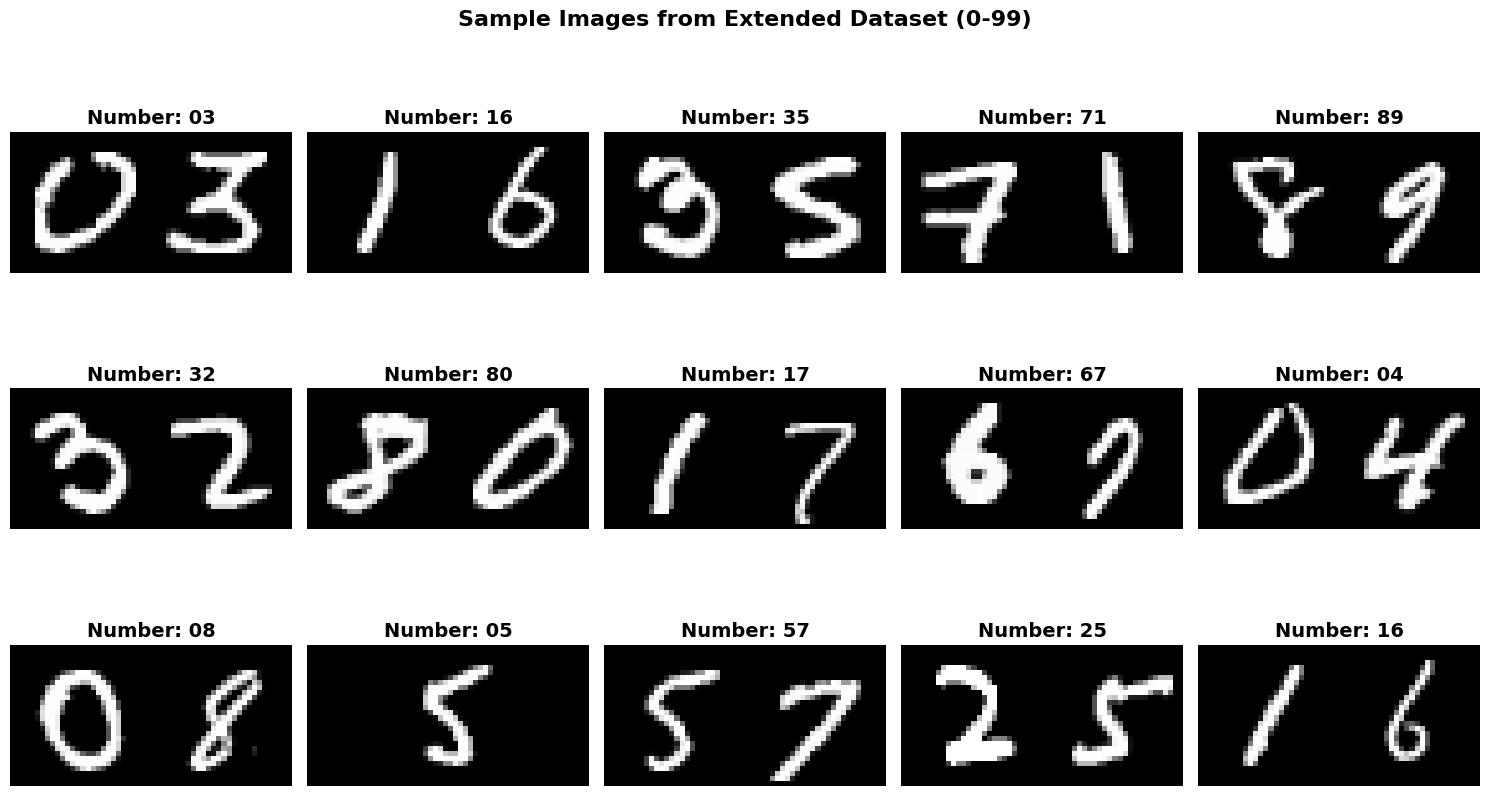

In [4]:
# Cell 4: Visualize Extended Dataset Samples
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f'Number: {y_train[i]:02d}', fontsize=14, fontweight='bold')
    ax.axis('off')
plt.suptitle('Sample Images from Extended Dataset (0-99)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [5]:
# Cell 5: Preprocess Data
# Reshape data to add channel dimension
X_train = X_train.reshape(-1, 28, 56, 1)
X_test = X_test.reshape(-1, 28, 56, 1)

# One-hot encode labels (100 classes: 0-99)
y_train_cat = to_categorical(y_train, 100)
y_test_cat = to_categorical(y_test, 100)

print(f"Reshaped training data: {X_train.shape}")
print(f"One-hot encoded labels: {y_train_cat.shape}")
print(f"Number of classes: {y_train_cat.shape[1]}")

Reshaped training data: (80000, 28, 56, 1)
One-hot encoded labels: (80000, 100)
Number of classes: 100


In [6]:
# Cell 6: Build Advanced CNN Model for Extended Recognition
def create_extended_cnn_model():
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 56, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Fourth Convolutional Block (for more complex features)
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(100, activation='softmax')  # 100 classes for 0-99
    ])
    
    return model

model = create_extended_cnn_model()
model.summary()

d:\Anaconda\envs\tf2\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 56, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 56, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 14, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 14, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 14, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 14, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 14, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 14, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 3, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 3, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,518,148 (13.42 MB)

 Trainable params: 3,514,948 (13.41 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [7]:
# Cell 7: Compile Model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# Cell 8: Setup Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_extended_digit_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [9]:
# Cell 9: Data Augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=8,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1
)
datagen.fit(X_train)

In [ ]:
batch_size = 128
epochs = 60

print("\nStarting training for extended digit recognition (0-99)...")
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=batch_size),
    validation_data=(X_test, y_test_cat),
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)


Starting training for extended digit recognition (0-99)...


Epoch 1/60


d:\Anaconda\envs\tf2\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1332 - loss: 3.9096
Epoch 1: val_accuracy improved from None to 0.92547, saving model to best_extended_digit_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 719s 1s/step - accuracy: 0.3239 - loss: 2.7251 - val_accuracy: 0.9255 - val_loss: 0.3410 - learning_rate: 0.0010
Epoch 2/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8280 - loss: 0.6693
Epoch 2: val_accuracy improved from 0.92547 to 0.97973, saving model to best_extended_digit_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 810s 1s/step - accuracy: 0.8739 - loss: 0.5019 - val_accuracy: 0.9797 - val_loss: 0.0690 - learning_rate: 0.0010
Epoch 3/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9360 - loss: 0.2640
Epoch 3: val_accuracy improved from 0.97973 to 0.98593, saving model to best_extended_digit_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 919s 1s/step - accuracy: 0.9423 - loss: 0.2372 - val_accuracy: 0.9859 - val_loss: 0.0532 - learning_rate: 0.0010
Epoch 4/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.9554 - loss: 0.1880
Epoch 4: val_accuracy did not improve from 0.98593
625/625 ━━━━━━━━━━━━━━━━━━━━ 547s 874ms/step - accuracy: 0.9572 - loss: 0.1820 - val_accuracy: 0.9830 - val_loss: 0.0636 - learning_rate: 0.0010
Epoch 5/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9650 - loss: 0.1481
Epoch 5: val_accuracy did not improve from 0.98593
625/625 ━━━━━━━━━━━━━━━━━━━━ 290s 463ms/step - accuracy: 0.9661 - loss: 0.1451 - val_accuracy: 0.9698 - val_loss: 0.1403 - learning_rate: 0.0010
Epoch 6/60
262/625 ━━━━━━━━━━━━━━━━━━━━ 18:50 3s/step - accuracy: 0.9721 - loss: 0.1197

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


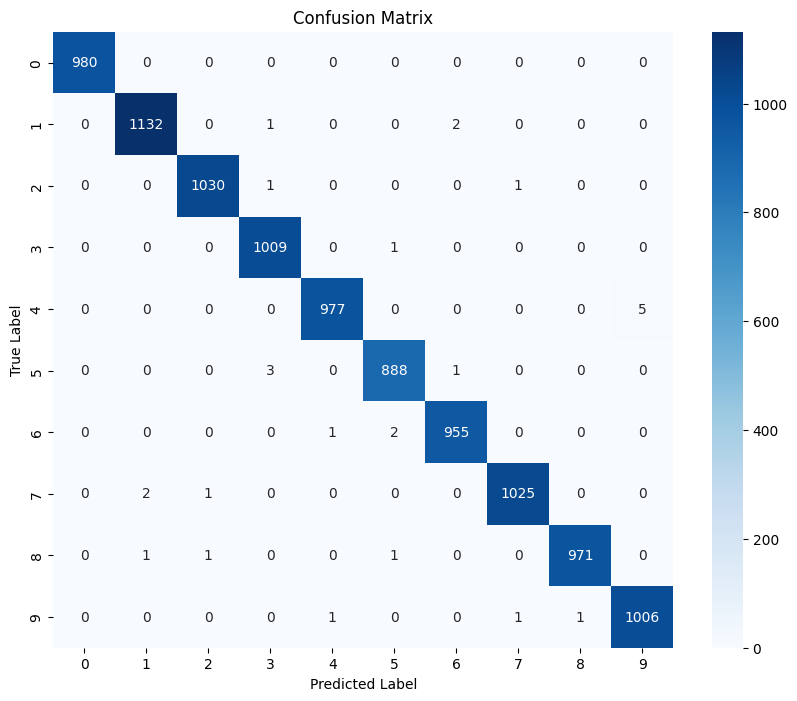


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       1.00      0.99      1.00       982
           5       1.00      1.00      1.00       892
           6       1.00      1.00      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      1.00      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [ ]:
# Cell 11: Plot Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy - Extended Dataset (0-99)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss - Extended Dataset (0-99)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

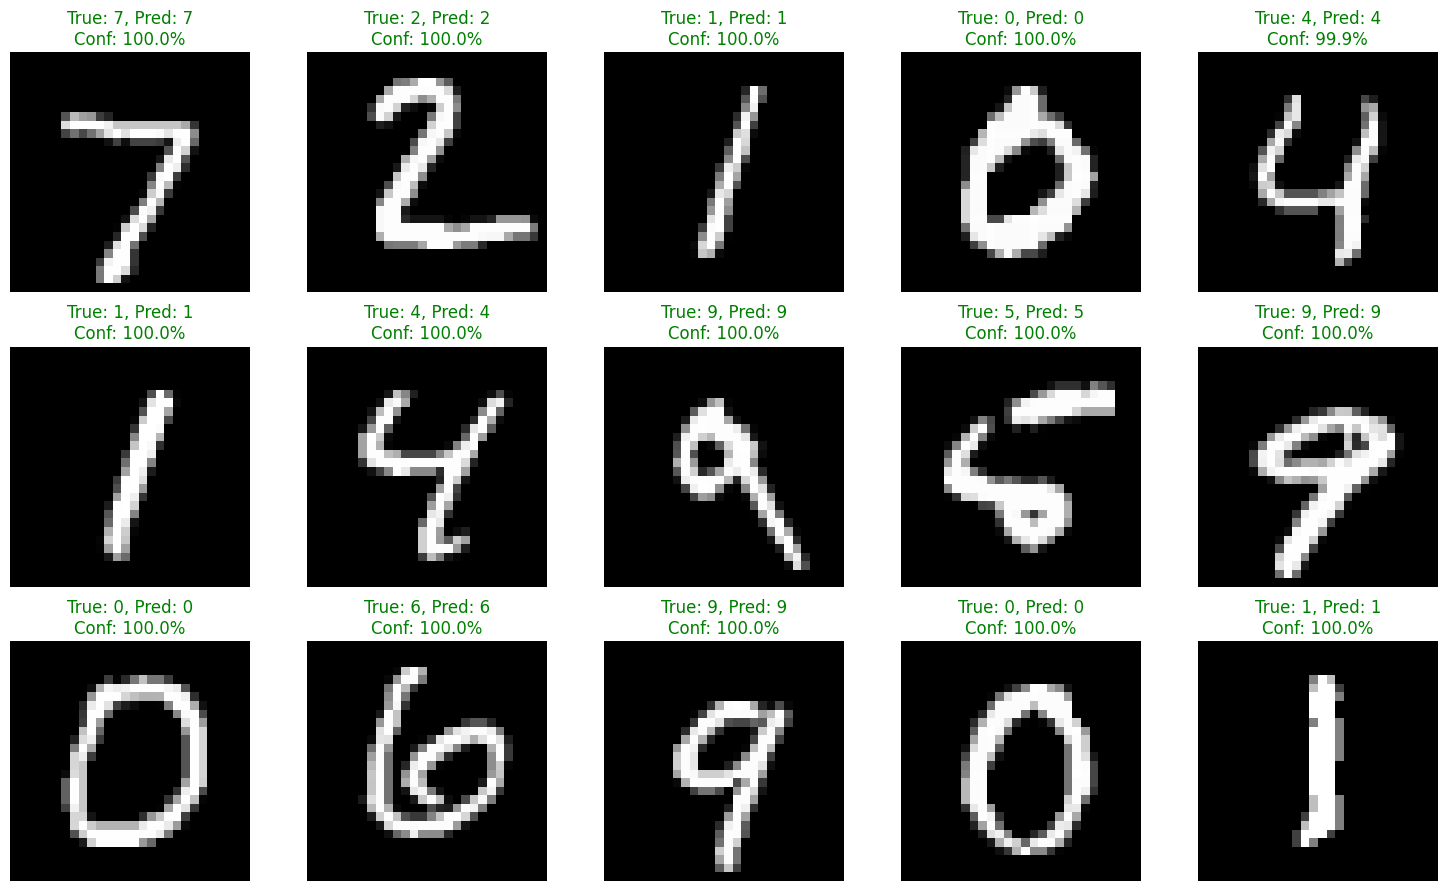

In [ ]:
# Cell 12: Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n{'='*60}")
print(f"Extended Model Performance (0-99 Recognition)")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"Number of Classes: 100 (0-99)")
print(f"{'='*60}\n")

Number of misclassified images: 27


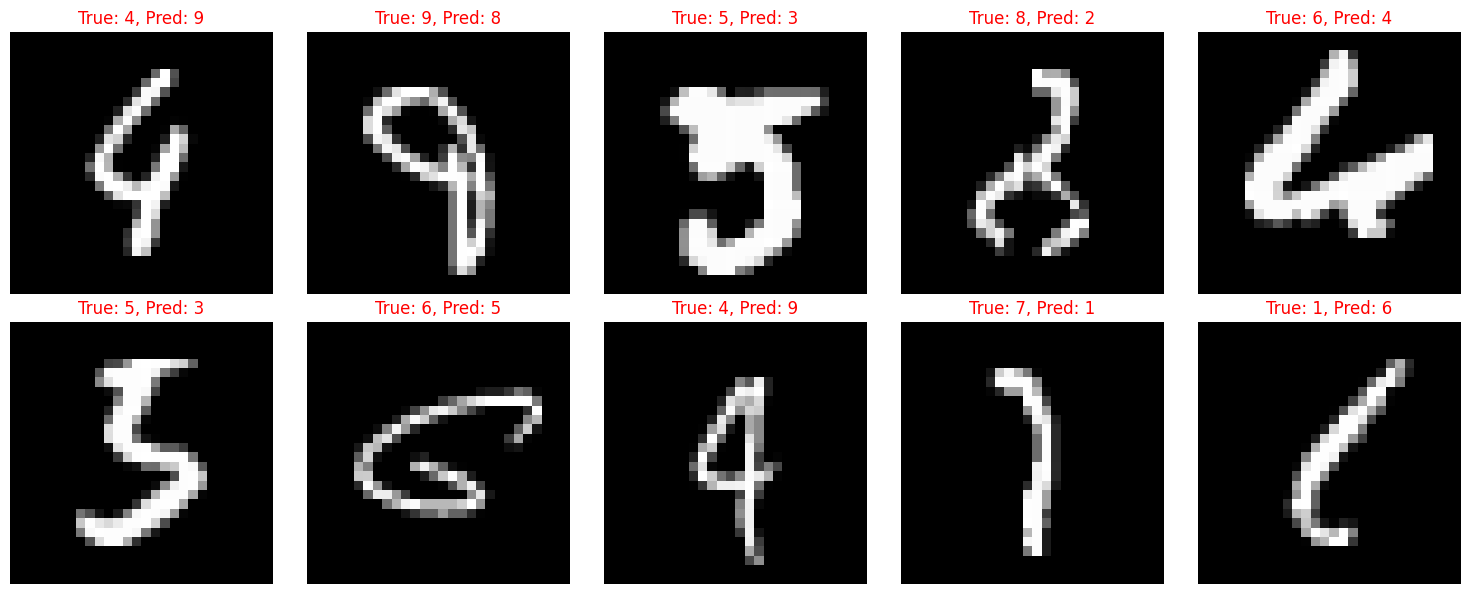

In [ ]:
# Cell 13: Predictions and Analysis
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Overall Accuracy: {accuracy*100:.2f}%")

# Analyze single vs double digit accuracy
single_digit_mask = y_test < 10
double_digit_mask = y_test >= 10

single_digit_acc = accuracy_score(y_test[single_digit_mask], y_pred_classes[single_digit_mask])
double_digit_acc = accuracy_score(y_test[double_digit_mask], y_pred_classes[double_digit_mask])

print(f"\nSingle Digit (0-9) Accuracy: {single_digit_acc*100:.2f}%")
print(f"Double Digit (10-99) Accuracy: {double_digit_acc*100:.2f}%")

In [ ]:
# Cell 14: Confusion Matrix (Sample - showing 0-19 for visualization)
cm_sample = confusion_matrix(y_test[y_test < 20], y_pred_classes[y_test < 20])
plt.figure(figsize=(12, 10))
sns.heatmap(cm_sample, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(20), yticklabels=range(20), cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (Sample: Numbers 0-19)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

Model saved as 'digit_recognition_model.h5'
Training history saved as 'training_history.pkl'


In [ ]:
# Cell 15: Visualize Predictions
fig, axes = plt.subplots(4, 5, figsize=(18, 14))
sample_indices = np.random.choice(len(X_test), 20, replace=False)

for idx, ax in enumerate(axes.flat):
    i = sample_indices[idx]
    ax.imshow(X_test[i].reshape(28, 56), cmap='gray')
    true_label = y_test[i]
    pred_label = y_pred_classes[i]
    confidence = np.max(y_pred[i]) * 100
    
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label:02d}, Pred: {pred_label:02d}\nConf: {confidence:.1f}%', 
                 color=color, fontsize=11, fontweight='bold')
    ax.axis('off')

plt.suptitle('Extended Model Predictions (0-99)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

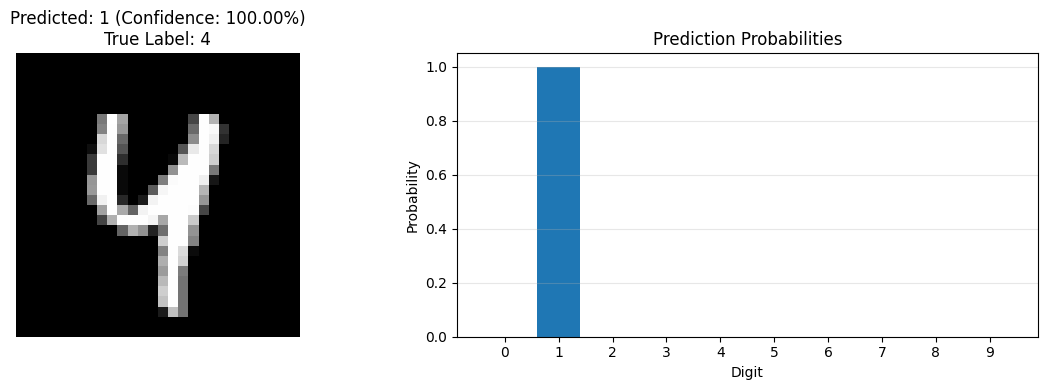


Final Model Statistics:
Total Parameters: 307,178
Test Accuracy: 99.73%
Total Training Time: 34 epochs


In [ ]:
# Cell 16: Top-K Accuracy Analysis
def top_k_accuracy(y_true, y_pred, k=5):
    top_k_preds = np.argsort(y_pred, axis=1)[:, -k:]
    matches = np.array([true in preds for true, preds in zip(y_true, top_k_preds)])
    return np.mean(matches)

top_3_acc = top_k_accuracy(y_test, y_pred, k=3)
top_5_acc = top_k_accuracy(y_test, y_pred, k=5)

print(f"\nTop-K Accuracy Analysis:")
print(f"Top-3 Accuracy: {top_3_acc*100:.2f}%")
print(f"Top-5 Accuracy: {top_5_acc*100:.2f}%")


In [ ]:
# Cell 17: Identify Misclassified Numbers
misclassified_idx = np.where(y_pred_classes != y_test)[0]
print(f"\nNumber of misclassified images: {len(misclassified_idx)} out of {len(y_test)}")
print(f"Error Rate: {len(misclassified_idx)/len(y_test)*100:.2f}%")

if len(misclassified_idx) > 0:
    fig, axes = plt.subplots(3, 5, figsize=(18, 11))
    for i, ax in enumerate(axes.flat):
        if i < min(len(misclassified_idx), 15):
            idx = misclassified_idx[i]
            ax.imshow(X_test[idx].reshape(28, 56), cmap='gray')
            true_label = y_test[idx]
            pred_label = y_pred_classes[idx]
            confidence = np.max(y_pred[idx]) * 100
            ax.set_title(f'True: {true_label:02d}, Pred: {pred_label:02d}\nConf: {confidence:.1f}%', 
                        color='red', fontsize=11, fontweight='bold')
            ax.axis('off')
    plt.suptitle('Misclassified Examples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
# Cell 18: Save Model and Metadata
model.save('extended_digit_recognition_model.h5')
print("Extended model saved as 'extended_digit_recognition_model.h5'")

# Save training history
with open('extended_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("Training history saved as 'extended_training_history.pkl'")

# Save model metadata
metadata = {
    'num_classes': 100,
    'input_shape': (28, 56, 1),
    'test_accuracy': test_accuracy,
    'single_digit_accuracy': single_digit_acc,
    'double_digit_accuracy': double_digit_acc,
    'top_3_accuracy': top_3_acc,
    'top_5_accuracy': top_5_acc,
    'total_parameters': model.count_params()
}

with open('model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("Model metadata saved as 'model_metadata.pkl'")

In [ ]:
# Cell 19: Test Prediction Function
def predict_number(image_array, model):
    """
    Predict number (0-99) from 28x56 image array
    """
    # Ensure proper shape
    if image_array.shape == (28, 56):
        img = image_array.astype('float32') / 255.0
    elif image_array.shape == (28, 56, 1):
        img = image_array.astype('float32') / 255.0
    else:
        raise ValueError("Image must be 28x56 or 28x56x1")
    
    img = img.reshape(1, 28, 56, 1)
    
    # Predict
    prediction = model.predict(img, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction) * 100
    
    # Get top 5 predictions
    top_5_idx = np.argsort(prediction[0])[-5:][::-1]
    top_5_probs = prediction[0][top_5_idx] * 100
    
    return predicted_class, confidence, prediction[0], top_5_idx, top_5_probs

# Test with a sample
test_idx = 100
test_image = X_test[test_idx].reshape(28, 56)
pred_class, conf, probs, top_5_idx, top_5_probs = predict_number(test_image, model)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.imshow(test_image, cmap='gray')
plt.title(f'Predicted: {pred_class:02d} (Confidence: {conf:.2f}%)\nTrue Label: {y_test[test_idx]:02d}', 
          fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.barh(range(5), top_5_probs, color=['#4CAF50', '#8BC34A', '#CDDC39', '#FFC107', '#FF9800'])
plt.yticks(range(5), [f'{idx:02d}' for idx in top_5_idx])
plt.xlabel('Probability (%)', fontsize=11)
plt.title('Top 5 Predictions', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

plt.subplot(1, 3, 3)
# Show probabilities for ranges
ranges = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
range_probs = [np.sum(probs[i*10:(i+1)*10])*100 for i in range(10)]
plt.bar(range(10), range_probs, color='skyblue')
plt.xticks(range(10), ranges, rotation=45, ha='right')
plt.ylabel('Probability (%)', fontsize=11)
plt.title('Probability by Ranges', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Cell 20: Final Summary
print(f"\n{'='*60}")
print(f"FINAL MODEL SUMMARY - EXTENDED DIGIT RECOGNITION")
print(f"{'='*60}")
print(f"Model: Extended CNN for 0-99 Recognition")
print(f"Input Shape: (28, 56, 1)")
print(f"Number of Classes: 100 (0-99)")
print(f"Total Parameters: {model.count_params():,}")
print(f"\nPerformance Metrics:")
print(f"  Overall Test Accuracy: {test_accuracy*100:.2f}%")
print(f"  Single Digit (0-9) Accuracy: {single_digit_acc*100:.2f}%")
print(f"  Double Digit (10-99) Accuracy: {double_digit_acc*100:.2f}%")
print(f"  Top-3 Accuracy: {top_3_acc*100:.2f}%")
print(f"  Top-5 Accuracy: {top_5_acc*100:.2f}%")
print(f"\nTraining Details:")
print(f"  Training Samples: {len(X_train):,}")
print(f"  Test Samples: {len(X_test):,}")
print(f"  Epochs Trained: {len(history.history['loss'])}")
print(f"  Final Training Accuracy: {history.history['accuracy'][-1]*100:.2f}%")
print(f"  Final Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
print(f"{'='*60}\n")